+ Model from : https://engmrk.com/vgg16-implementation-using-keras/

+ Codigo: https://androidkt.com/how-to-use-vgg-model-in-tensorflow-keras/

+ Codigo: https://lambdalabs.com/blog/tensorflow-2-0-tutorial-01-image-classification-basics/
https://torres.ai/data-augmentation-y-transfer-learning-en-keras-tensorflow/

+ How to use Learning courves: https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [ ]:
# clonar repositorio 
! git clone https://github.com/fabrilopez/datasets.git

Cloning into 'datasets'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 2041 (delta 1), reused 8 (delta 1), pack-reused 2031
Receiving objects: 100% (2041/2041), 247.06 MiB | 37.92 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (2416/2416), done.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pathlib

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [ ]:
tf.__version__

'2.0.0'

In [ ]:
data_dir = 'datasets/dataset_500'
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/dataset_500')

In [ ]:
label_names={'aca_315': 0, 'buck_guapo': 1, 'buck_meteoro': 2, 'klein_escorpion': 3}
label_names

{'aca_315': 0, 'buck_guapo': 1, 'buck_meteoro': 2, 'klein_escorpion': 3}

In [ ]:
BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [ ]:
all_images = list(data_dir.glob('*/*'))
all_images = [str(path) for path in all_images]
random.shuffle(all_images)

all_labels=[label_names[pathlib.Path(path).parent.name] for path in all_images]

data_size = len(all_images)

train_test_split = (int)(data_size*0.2)

x_train = all_images[train_test_split:]
y_train = all_labels[train_test_split:]

x_validation = all_images[:train_test_split]
y_validation = all_labels[:train_test_split]


In [ ]:
len(x_train), len(y_train), len(x_validation), len(y_validation)

(1600, 1600, 400, 400)

In [ ]:
def decode_img(x,y):
  image = tf.io.read_file(x)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_WIDTH, IMG_HEIGHT))
  return image,y

In [ ]:
def create_ds(x,y):
  ds = tf.data.Dataset.from_tensor_slices((x,y))
  ds = ds.map(decode_img)
  ds = ds.shuffle(buffer_size=len(x))
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [ ]:
train_ds = create_ds(x_train,y_train)
validation_ds=create_ds(x_validation,y_validation)

In [ ]:
train_ds, validation_ds

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>)

In [ ]:
VGG16_MODEL=tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

58892288/58889256 [==============================] - 2s 0us/step


In [ ]:
VGG16_MODEL.trainable=False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(label_names),activation='softmax')

In [ ]:
model = tf.keras.Sequential([
  VGG16_MODEL,
  global_average_layer,  
  Dense(4096, activation='relu'),
  prediction_layer
])

In [ ]:
VGG16_MODEL.summary()
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [ ]:
history = model.fit(train_ds, 
                    epochs=30, 
                    steps_per_epoch=8, 
                    validation_steps=8, 
                    validation_data=validation_ds)

Train for 8 steps, validate for 8 steps
Epoch 1/30
8/8 [==============================] - 52s 6s/step - loss: 1.4951 - accuracy: 0.3223 - val_loss: 1.4109 - val_accuracy: 0.3867
Epoch 2/30
8/8 [==============================] - 17s 2s/step - loss: 1.2009 - accuracy: 0.4844 - val_loss: 1.1055 - val_accuracy: 0.5410
Epoch 3/30
8/8 [==============================] - 16s 2s/step - loss: 1.0248 - accuracy: 0.5742 - val_loss: 1.0378 - val_accuracy: 0.6074
Epoch 4/30
8/8 [==============================] - 40s 5s/step - loss: 0.9457 - accuracy: 0.6094 - val_loss: 1.0216 - val_accuracy: 0.5820
Epoch 5/30
8/8 [==============================] - 16s 2s/step - loss: 0.9591 - accuracy: 0.5801 - val_loss: 0.9691 - val_accuracy: 0.5859
Epoch 6/30
8/8 [==============================] - 17s 2s/step - loss: 0.8236 - accuracy: 0.6504 - val_loss: 1.0337 - val_accuracy: 0.5332
Epoch 7/30
8/8 [==============================] - 40s 5s/step - loss: 0.8864 - accuracy: 0.6270 - val_loss: 0.9684 - val_accuracy: 0

In [ ]:
validation_steps = 20
 
loss0,accuracy0 = model.evaluate(validation_ds, steps = validation_steps)
 
print("loss: {:.2f}".format(loss0))
print("accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 28s 1s/step - loss: 0.6244 - accuracy: 0.7719
loss: 0.62
accuracy: 0.77


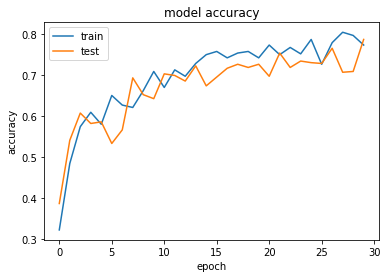

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

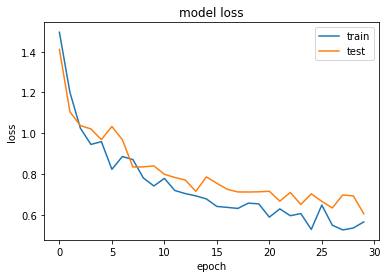

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# saves the weights of the model as a HDF5 file.
# model.save_weights('datasets/vgg16_07_weights.h5')

In [ ]:
# creates a HDF5 file 'my_model.h5'
model.save('datasets/vgg16_07_model.h5')  

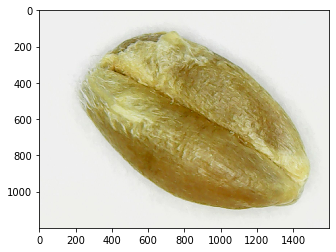

In [ ]:
# make a prediction
#image_name = 'datasets/dataset_f/klein_escorpion/kleinescorpion_0055.jpg'
image_name = 'datasets/dataset_f/aca_315/aca315_0012.jpg'
image = tf.io.read_file(image_name)
image = tf.image.decode_jpeg(image, channels=3)
plt.imshow(image)
image = tf.cast(image, tf.float32)
image = (image/127.5) - 1
image = tf.image.resize(image, (IMG_WIDTH, IMG_HEIGHT))
image4d = tf.expand_dims(image,0)
prediction = model.predict(image4d)

In [ ]:
print(prediction)

[[0.95171046 0.00141997 0.03139884 0.01547073]]


In [ ]:
np_key = np.argmax(prediction)
for label, key in label_names.items():
  if key == np_key:
    print('La semilla seleccionada pertenece a la variedad: ' + label)

La semilla seleccionada pertenece a la variedad: aca_315


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


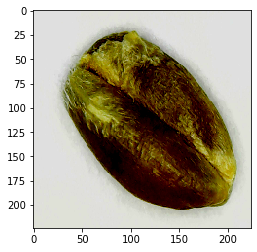

In [ ]:
plt.imshow(image)
plt.show()